# Access UP42 assets with PySTAC

[UP42](https://up42.com/) is a platform for accessing data from various geospatial providers.

* [SpatioTemporal Asset Catalog](https://stacspec.org/en/) (STAC) is a specification designed to establish a standard in geospatial data.
* [PySTAC](https://pystac.readthedocs.io/en/stable/) is a library for working with STAC.

This tutorial explains how to get STAC collections and STAC items associated with the UP42 assets in your storage and visualize them on a map. For more information, see [UP42's introduction to STAC](https://docs.up42.com/developers/api-assets/stac-about).

1. [Import libraries](#import)
2. [Create an UP42 access token](#token)
3. [Create a PySTAC-Client connection](#pystac-client)
4. [Get STAC collections](#collections)
5. [Get STAC items](#items)
6. [Make a detailed STAC item search](#search)
7. [Download and visualize results](#download-visualize)

## Import libraries <a class="anchor" id="import"></a>

In [ ]:
!pip install pystac-client requests rasterio geopandas matplotlib contextily

In [2]:
import requests, base64

import pystac_client
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

from zipfile import ZipFile

## Create an UP42 access token <a class="anchor" id="token"></a>


In [3]:
USERNAME = "your-username"
PASSWORD = "your-password"

### Generate an access token <a class="anchor" id="access"></a>

The cell below creates an access token using your credentials.

In [ ]:
def get_auth_token_prod(username, password):
    """Authentication based on UP42 username and password"""
    AUTH_URL = "https://api.up42.com/oauth/token"
    req_headers = {
        "Content-Type": "application/x-www-form-urlencoded",
    }
    req_body = {
        "grant_type": "password",
        "username": username,
        "password": password}
    response = requests.post(AUTH_URL, data=req_body, headers=req_headers)
    return response.json()['data']['accessToken']

In [5]:
def create_auth_token(username, password, env):
    if (env == "prod"):
        UP42_signed_token = get_auth_token_prod(username, password)
    return UP42_signed_token

## Create a PySTAC-Client connection <a class="anchor" id="pystac-client"></a>

In [6]:
def create_pystac_client(url, username, password, env):
    UP42_signed_token = create_auth_token(username, password, env)
    UP42_client = pystac_client.Client.open(
        url=url,
        headers= {
            'Authorization': f"Bearer {UP42_signed_token}",
        }
    )
    return UP42_client

In [7]:
PROD_URL = "https://api.up42.com"
CATALOG_URL = "/v2/assets/stac"
UP42_stac_catalog_url = PROD_URL + CATALOG_URL

In [8]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")

## Get STAC collections <a class="anchor" id="collections"></a>

A STAC collection is an UP42 asset you received after a completed order. An order can produce multiple STAC collections. A STAC collection contains different storage characteristics — for example, a [geospatial collection](https://docs.up42.com/data/datasets) name, a producer name, a corresponding UP42 asset ID.

For more information on STAC collections, see [Intro to STAC](https://stacspec.org/en/tutorials/intro-to-stac/#STAC-Collection) and [STAC Collection Specification](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md).

In [9]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")
UP42_client_stac_collections = list(UP42_client.get_collections())
len(UP42_client_stac_collections)

1246

The cell below retrieves the following information about your STAC collections:
* A STAC collection title
* A STAC Collection ID
* A respective UP42 order ID
* A respective UP42 asset ID

In [10]:
for stac_collection in UP42_client_stac_collections[:3]: # Displays only the first 3 results
    print('------------ COLLECTION -------------')
    print('Title:              ', stac_collection.title)
    print('STAC Collection ID: ', stac_collection.id)
    current_stac_collection = getattr(stac_collection, 'extra_fields')
    print('Asset ID:           ', current_stac_collection['up42-system:asset_id'])
    if('up42-order:id' in current_stac_collection):
        print(f"Order ID:            {current_stac_collection['up42-order:id']}")
    print('------------ END -------------')

stac_collection_id_asset = UP42_client_stac_collections[0].id # Selects the first collection to get its items later

------------ COLLECTION -------------
Title:               PNEO4_202304070656155_PAN_SEN
STAC Collection ID:  4ecf5965-3fa0-4e9b-a822-ad74a5dd18a4
Asset ID:            405527cf-1a7e-428f-85d0-8f19cfdb0d5b
Order ID:            d7574551-aa40-4214-8c38-d1741a983192
------------ END -------------
------------ COLLECTION -------------
Title:               PNEO3_202303150703480_PAN_SEN
STAC Collection ID:  f9ab4697-8bd4-4284-870c-58472a31f909
Asset ID:            7652f727-c071-4f06-a8d2-31ee15681403
Order ID:            d7574551-aa40-4214-8c38-d1741a983192
------------ END -------------
------------ COLLECTION -------------
Title:               PNEO3_202304100703416_PAN_SEN
STAC Collection ID:  772816ae-be60-4e89-b35a-0b7ec1d8db82
Asset ID:            d20acd73-4327-47b8-95ad-e5628f4376ff
Order ID:            d7574551-aa40-4214-8c38-d1741a983192
------------ END -------------


You can also get information about a particular STAC collection by using its ID.

In [11]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")
client_single_stac_collection = UP42_client.get_collection(stac_collection_id_asset)
client_single_stac_collection

ID: 4ecf5965-3fa0-4e9b-a822-ad74a5dd18a4
Title: PNEO4_202304070656155_PAN_SEN
Description: Very high-resolution 30cm Pleiades Neo images acquired bidaily on a global basis. The datasets are available starting from November 2021.
Providers: AIRBUS DS GEO (producer) AIRBUS DS GEO (processor)
assets: {}
"stac_extensions: ['https://api.up42.com/stac-extensions/up42-product/v1.0.0/schema.json', 'https://api.up42.com/stac-extensions/up42-system/v1.0.0/schema.json', 'https://api.up42.com/stac-extensions/up42-order/v1.0.0/schema.json']"
title: PNEO4_202304070656155_PAN_SEN
"keywords: ['Airbus', 'PléiadesNeo']"
"providers: [{'name': 'AIRBUS DS GEO', 'roles': ['producer'], 'url': 'http://www.geo-airbusds.com/'}, {'name': 'AIRBUS DS GEO', 'roles': ['processor'], 'url': 'http://www.geo-airbusds.com/'}]"
type: Collection
summaries: {}


## Get STAC items <a class="anchor" id="items"></a>

A STAC item is an individual scene that represents inseparable data and metadata. A STAC item has a unique spatiotemporal extent, that is, has one AOI and acquisition time in its characteristics. For example, an order with a stereo acquisition mode will produce a STAC collection with two STAC items — one for each image of a slightly different AOI.

In UP42 API every STAC item is attributed to a STAC collection.

For more information on STAC items, see [Intro to STAC](https://stacspec.org/en/tutorials/intro-to-stac/#STAC-Item) and [STAC Item Specification](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md).

In [12]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")
stac_item_scene = client_single_stac_collection.get_items()
for i, stac_item in enumerate(stac_item_scene):
    print(f"{i}: Image in asset <{stac_item.id}>")
last_item = stac_item.id

0: Image in asset <9afbdf4a-25cd-4399-929e-b7d196b17732>
1: Image in asset <78691837-3b41-48e5-a452-e43f080a1c1e>


You can also get information about a particular STAC item by using its ID.

In [13]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")
stac_item_selected = client_single_stac_collection.get_item(last_item)
stac_item_selected

ID: 78691837-3b41-48e5-a452-e43f080a1c1e
"Bounding Box: [54.31793246860514, 17.019094292371896, 54.411631253185675, 17.088556590348343]"
Datetime: 2023-04-07 06:56:15+00:00
gsd: 0.3223558053221487
title: PNEO4_202304070656155_PAN_SEN_R1C1
datetime: 2023-04-07T06:56:15+00:00
platform: PNEO-4
proj:epsg: None
end_datetime: 2023-04-07T06:56:15+00:00
view:azimuth: 134.7416633519389
constellation: PNEO


To see only certain fields, preselect them. The cell below retrieves the following information about your STAC item:
* A STAC item ID
* A STAC item acquisition date
* A respective UP42 asset ID

In [14]:
print(f"STAC Item ID:     {stac_item_selected.id}")
print(f"Acquisition date: {stac_item_selected.properties['datetime']}")
print(f"Asset ID:         {stac_item_selected.properties['up42-system:asset_id']}")

STAC Item ID:     78691837-3b41-48e5-a452-e43f080a1c1e
Acquisition date: 2023-04-07T06:56:15+00:00
Asset ID:         405527cf-1a7e-428f-85d0-8f19cfdb0d5b


## Make a detailed STAC item search <a class="anchor" id="search"></a>

Instead of searching for all STAC items, you can make a detailed search request to find specific STAC items in your storage.

Examples of usage:
* [Search by date](#date)
* [Search by cloud coverage](#cloud)
* [Search by AOI](#aoi)

To learn about other search options, see [Detailed STAC item search](https://docs.up42.com/developers/api-assets/stac-items-search).

### Search by date <a class="anchor" id="date"></a>

You can search for STAC items with a specific date and time, or those that fall within a closed or an open date interval. Example values:
* `"2018-02-12T23:20:50Z"`
* `"2018-02-12T00:00:00Z/2018-03-18T12:31:12Z"`
* `"2018-02-12T00:00:00Z/.."`
* `"../2018-03-18T12:31:12Z"`

In [15]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")
date_filter = "2022-11-01T00:00:00.000000Z/2022-12-31T00:00:00.000000Z" # Specifies the acquisition period
stac_items_search = UP42_client.search(
    max_items = 100,
    limit = 5,
    datetime = date_filter,
    method="POST"
)
stac_items = [UP42_client.get_item(stac_item.id).to_dict() for stac_item in list(stac_items_search.items())]
df = gpd.GeoDataFrame.from_features(stac_items)
df

,geometry,gsd,title,datetime,platform,proj:epsg,end_datetime,view:azimuth,constellation,up42-order:id,...,up42-system:asset_id,view:incidence_angle,up42-product:modality,up42-product:data_type,up42-system:account_id,up42-product:product_id,up42-system:workspace_id,up42-product:collection_name,up42-system:metadata_version,up42-user:tags
0,"POLYGON ((-101.38854 37.18464, -101.38118 37.1...",0.764097,DS_PHR1B_202212261732491_FR1_PX_W102N37_0804_0...,2022-12-26T17:33:26.100000Z,PHR-1B,32614.0,2022-12-26T17:33:26.100000+00:00,180.038873,PHR,43f60d6b-844c-491f-87d7-fd8e698a2d38,...,140e4423-29bd-4c58-afc8-6f2394fc2329,19.565663,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,647780db-5a06-4b61-b525-577a8b68bb54,133bc5e5-2b94-4a4a-a650-75cd222f6886,phr,0.0.5,NaN
1,"POLYGON ((-74.86745 11.04578, -74.85795 11.045...",2.449550,ORT_SPOT6_20221101_150806500_000_R1C1,2022-11-01T15:08:03.600000Z,SPOT-6,32618.0,2022-11-01T15:08:03.600000+00:00,355.097938,SPOT,2fe7fad5-7da1-4663-9839-24451218b003,...,84d0d467-d754-4d98-b861-a7ac0fea7e39,22.143217,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,acc3f9a4-b622-49c1-b1e1-c762aa3e7e13,b5933e3d-8383-4495-9b6b-73073d213c29,spot,0.0.4,NaN
2,"POLYGON ((-81.59335 29.91579, -81.59335 29.881...",0.315188,PNEO4_202212181620589_PAN_SEN_R2C1,2022-12-18T16:20:58Z,PNEO-4,NaN,2022-12-18T16:20:58+00:00,264.352415,PNEO,NaN,...,e5047ecb-43aa-4f2f-96f3-2f6613497334,15.958285,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,eb1626d2-8015-43e9-acab-fbfaee89466c,NaN,0.0.4,NaN
3,"POLYGON ((-81.59335 30.00170, -81.59335 29.915...",0.315188,PNEO4_202212181620589_PAN_SEN_R1C1,2022-12-18T16:20:58Z,PNEO-4,NaN,2022-12-18T16:20:58+00:00,264.352415,PNEO,NaN,...,e5047ecb-43aa-4f2f-96f3-2f6613497334,15.958285,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,eb1626d2-8015-43e9-acab-fbfaee89466c,NaN,0.0.4,NaN
4,"POLYGON ((-81.59339 29.91372, -81.59339 29.878...",0.325509,PNEO4_202212181621109_PAN_SEN_R2C1,2022-12-18T16:21:10Z,PNEO-4,NaN,2022-12-18T16:21:10+00:00,241.740252,PNEO,NaN,...,01f8a8e4-f8f0-4c1b-8f5a-d243f3013d19,19.954736,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,eb1626d2-8015-43e9-acab-fbfaee89466c,NaN,0.0.4,NaN
5,"POLYGON ((-81.59339 30.00484, -81.59339 29.913...",0.325509,PNEO4_202212181621109_PAN_SEN_R1C1,2022-12-18T16:21:10Z,PNEO-4,NaN,2022-12-18T16:21:10+00:00,241.740252,PNEO,NaN,...,01f8a8e4-f8f0-4c1b-8f5a-d243f3013d19,19.954736,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,eb1626d2-8015-43e9-acab-fbfaee89466c,NaN,0.0.4,NaN
6,"POLYGON ((-81.59331 29.91280, -81.59331 29.880...",0.320708,PNEO4_202212181620358_PAN_SEN_R2C1,2022-12-18T16:20:34.900000Z,PNEO-4,NaN,2022-12-18T16:20:34.900000+00:00,318.093868,PNEO,NaN,...,06950959-882e-453b-a0c7-e0a5f2f41136,18.151293,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,eb1626d2-8015-43e9-acab-fbfaee89466c,NaN,0.0.4,NaN
7,"POLYGON ((-81.59331 30.00444, -81.59331 29.912...",0.320708,PNEO4_202212181620358_PAN_SEN_R1C1,2022-12-18T16:20:34.900000Z,PNEO-4,NaN,2022-12-18T16:20:34.900000+00:00,318.093868,PNEO,NaN,...,06950959-882e-453b-a0c7-e0a5f2f41136,18.151293,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,eb1626d2-8015-43e9-acab-fbfaee89466c,NaN,0.0.4,NaN
8,"POLYGON ((-73.07515 11.45096, -73.07250 11.431...",2.422049,ORT_SPOT6_20221225_145340800_000_R1C1,2022-12-25T14:53:37.900000Z,SPOT-6,32618.0,2022-12-25T14:53:37.900000+00:00,50.887245,SPOT,ecd332e4-e51f-4b47-888e-bb7d8b1b01a4,...,0ba5590b-c606-40d5-89ad-95e85cf8702a,20.794449,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,b1f8c48e-d16b-44c4-a1bb-5e8a24892e69,b5933e3d-8383-4495-9b6b-73073d213c29,spot,0.0.4,NaN
9,"POLYGON ((-74.09608 44.39971, -74.09608 44.359...",0.745549,DS_PHR1A_202211031559528_FR1_PX_W075N44_1111_0...,2022-11-03T16:00:29.800000Z,PHR-1A,4326.0,2022-11-03T16:00:29.800000+00:00,179.980164,PHR,NaN,...,639b9aa5-3970-457a-aa45-06423865bdfe,16.769643,multispectral,raster,3c86279b-610a-4dba-ad1

### Search by cloud coverage <a class="anchor" id="cloud"></a>

You can search for STAC items with cloud coverage greater or less than a chosen value. Example values:
* Cloud coverage equal to 20
    ```
    "op": "eq",
    "args": [{"property": "cloud_cover"}, 20]
    ```
* Cloud coverage less than or equal to 50
    ```
    "op": "lte",
    "args": [{"property": "cloud_cover"}, 50]
    ```

The cell below searches for STAC items with cloud coverage greater than or equal to 10.

In [18]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")
params = {
    "max_items": 10,
    "limit" : 5,
    "method":"POST"

}
params['filter'] = {
    "op": "lte",
    "args": [{"property": "cloud_cover"}, 10] # Specifies the cloud coverage
}

stac_items_search = UP42_client.search(
    **params
)
stac_items = [UP42_client.get_item(stac_item.id).to_dict() for stac_item in list(stac_items_search.items())]
df = gpd.GeoDataFrame.from_features(stac_items)
df

,geometry,gsd,title,datetime,platform,proj:epsg,end_datetime,view:azimuth,constellation,up42-order:id,...,view:sun_elevation,up42-system:asset_id,view:incidence_angle,up42-product:modality,up42-product:data_type,up42-system:account_id,up42-product:product_id,up42-system:workspace_id,up42-product:collection_name,up42-system:metadata_version
0,"POLYGON ((54.41163 17.08856, 54.41163 17.01909...",0.322356,PNEO4_202304070656155_PAN_SEN_R1C2,2023-04-07T06:56:15Z,PNEO-4,NaN,2023-04-07T06:56:15+00:00,134.741663,PNEO,d7574551-aa40-4214-8c38-d1741a983192,...,66.072066,405527cf-1a7e-428f-85d0-8f19cfdb0d5b,18.885310,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,07c33a51-94b9-4509-84df-e9c13ea92b84,313ba781-8aee-4585-b045-77eafa1fb592,pneo-tasking,0.0.5
1,"POLYGON ((54.31793 17.08856, 54.31793 17.01909...",0.322356,PNEO4_202304070656155_PAN_SEN_R1C1,2023-04-07T06:56:15Z,PNEO-4,NaN,2023-04-07T06:56:15+00:00,134.741663,PNEO,d7574551-aa40-4214-8c38-d1741a983192,...,66.072066,405527cf-1a7e-428f-85d0-8f19cfdb0d5b,18.885310,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,07c33a51-94b9-4509-84df-e9c13ea92b84,313ba781-8aee-4585-b045-77eafa1fb592,pneo-tasking,0.0.5
2,"POLYGON ((54.29508 17.04733, 54.29508 17.01099...",0.315764,PNEO3_202303150703480_PAN_SEN_R2C2,2023-03-15T07:03:47Z,PNEO-3,NaN,2023-03-15T07:03:47+00:00,179.999210,PNEO,d7574551-aa40-4214-8c38-d1741a983192,...,60.940894,7652f727-c071-4f06-a8d2-31ee15681403,16.002227,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,07c33a51-94b9-4509-84df-e9c13ea92b84,313ba781-8aee-4585-b045-77eafa1fb592,pneo-tasking,0.0.5
3,"POLYGON ((54.29508 17.13697, 54.29508 17.04733...",0.315764,PNEO3_202303150703480_PAN_SEN_R1C2,2023-03-15T07:03:47Z,PNEO-3,NaN,2023-03-15T07:03:47+00:00,179.999210,PNEO,d7574551-aa40-4214-8c38-d1741a983192,...,60.940894,7652f727-c071-4f06-a8d2-31ee15681403,16.002227,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,07c33a51-94b9-4509-84df-e9c13ea92b84,313ba781-8aee-4585-b045-77eafa1fb592,pneo-tasking,0.0.5
4,"POLYGON ((54.20540 17.04733, 54.20540 17.01099...",0.315764,PNEO3_202303150703480_PAN_SEN_R2C1,2023-03-15T07:03:47Z,PNEO-3,NaN,2023-03-15T07:03:47+00:00,179.999210,PNEO,d7574551-aa40-4214-8c38-d1741a983192,...,60.940894,7652f727-c071-4f06-a8d2-31ee15681403,16.002227,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,07c33a51-94b9-4509-84df-e9c13ea92b84,313ba781-8aee-4585-b045-77eafa1fb592,pneo-tasking,0.0.5
5,"POLYGON ((54.20540 17.13697, 54.20540 17.04733...",0.315764,PNEO3_202303150703480_PAN_SEN_R1C1,2023-03-15T07:03:47Z,PNEO-3,NaN,2023-03-15T07:03:47+00:00,179.999210,PNEO,d7574551-aa40-4214-8c38-d1741a983192,...,60.940894,7652f727-c071-4f06-a8d2-31ee15681403,16.002227,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,07c33a51-94b9-4509-84df-e9c13ea92b84,313ba781-8aee-4585-b045-77eafa1fb592,pneo-tasking,0.0.5
6,"POLYGON ((13.30900 52.40806, 13.30900 52.42249...",2.448952,ORT_SPOT6_20220624_095907600_000_R1C1,2022-06-24T09:59:07.500000Z,SPOT-6,4326.0,2022-06-24T09:59:07.500000+00:00,329.861311,SPOT,NaN,...,58.064102,50350687-93d5-4367-ae89-1daaa09dce17,21.395250,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,a917e589-1187-402f-8bf8-38937d6fe713,NaN,0.0.5
7,"POLYGON ((13.37685 52.50025, 13.37450 52.50394...",2.279563,ORT_SPOT7_20210531_095152300_000_R1C1,2021-05-31T09:51:52.100000Z,SPOT-7,4326.0,2021-05-31T09:51:52.100000+00:00,353.945963,SPOT,NaN,...,56.481698,10d5e67a-5318-4737-b7b7-c5cfdaf51891,11.673916,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,a917e589-1187-402f-8bf8-38937d6fe713,NaN,0.0.5
8,"POLYGON ((13.30900 52.40806, 13.30900 52.42249...",2.448952,ORT_SPOT6_20220624_095907600_000_R1C1,2022-06-24T09:59:07.500000Z,SPOT-6,4326.0,2022-06-24T09:59:07.500000+00:00,329.861311,SPOT,NaN,...,58.064102,9000a83c-23cf-4b78-b3e9-000fd6066662,21.395250,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,NaN,a917e589-1187-402f-8bf8-38937d6fe713,NaN,0.0.5
9,"POLYGON ((13.37685 52.50025, 13

### Search by AOI <a class="anchor" id="aoi"></a>

Use a GeoJSON format to search for STAC items that have a specific AOI.

In [19]:
aoi_geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [ -74.8500, 10.950 ],
            [ -74.8500, 11.050 ],
            [ -74.7900, 11.050 ],
            [ -74.7900, 10.950 ],
            [ -74.8500, 10.950 ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

aoi_geometry = aoi_geojson["features"][0]["geometry"]

In [20]:
UP42_client = create_pystac_client(UP42_stac_catalog_url, username=USERNAME, password=PASSWORD, env="prod")
stac_items_search = UP42_client.search(
    max_items = 100,
    limit = 5,
    intersects = aoi_geometry,
    method="POST"
)
stac_items = [UP42_client.get_item(stac_item.id).to_dict() for stac_item in list(stac_items_search.items())]
df = gpd.GeoDataFrame.from_features(stac_items)
df

,geometry,gsd,title,datetime,platform,proj:epsg,end_datetime,view:azimuth,constellation,up42-order:id,...,view:sun_elevation,up42-system:asset_id,view:incidence_angle,up42-product:modality,up42-product:data_type,up42-system:account_id,up42-product:product_id,up42-system:workspace_id,up42-product:collection_name,up42-system:metadata_version
0,"POLYGON ((-74.81195 11.00837, -74.80643 11.008...",0.819638,DS_PHR1B_202204121545560_FR1_PX_W075N10_0324_0...,2022-04-12T15:46:33Z,PHR-1B,32618,2022-04-12T15:46:33+00:00,179.978640,PHR,42b3f43b-6f4b-43b8-903a-a9356ae528cc,...,71.791029,df25086d-28e2-4789-a334-12afd19db933,26.244099,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,647780db-5a06-4b61-b525-577a8b68bb54,b5933e3d-8383-4495-9b6b-73073d213c29,phr,0.0.4
1,"POLYGON ((-74.79049 10.99074, -74.78901 10.990...",2.453793,ORT_SPOT6_20221101_150807300_000_R1C1,2022-11-01T15:08:03.600000Z,SPOT-6,32618,2022-11-01T15:08:03.600000+00:00,352.994323,SPOT,37d1bb27-9588-4da7-8cf2-8f3b0b418420,...,55.338345,2330d5be-d1dd-499d-8abd-5ba646e3fc54,22.304576,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,acc3f9a4-b622-49c1-b1e1-c762aa3e7e13,b5933e3d-8383-4495-9b6b-73073d213c29,spot,0.0.4
2,"POLYGON ((-74.80585 10.99368, -74.79921 10.991...",0.822566,DS_PHR1B_202301041541410_FR1_PX_W075N10_0324_0...,2023-01-04T15:42:18Z,PHR-1B,32618,2023-01-04T15:42:18+00:00,179.995685,PHR,61c9d0a3-8952-4d74-ade8-6dcf60acb845,...,50.801722,eb4339e9-a1ad-40b5-b8cf-91f165bc5c22,26.527152,multispectral,raster,3c86279b-610a-4dba-ad12-abe3bdc51428,647780db-5a06-4b61-b525-577a8b68bb54,b5933e3d-8383-4495-9b6b-73073d213c29,phr,0.0.4


## Download and visualize results <a class="anchor" id="download-visualize"></a>

1. [Download UP42 assets](#download)
2. [Visualize results](#visualize)

### Download UP42 assets <a class="anchor" id="download"></a>

You can download respective UP42 assets associated with STAC collections or STAC items.

In [21]:
def download_extract_asset(url, asset_list, token):
    '''Downloads an asset from UP42 storage based on UP42 asset ID'''
    header={
        'Authorization': f"Bearer {token}",
    }
    for asset_id in asset_list:
        DOWNLOAD_ENDPOINT = f"/v2/assets/{asset_id}/"
        DOWNLOAD_URL = url + DOWNLOAD_ENDPOINT
        filepath = f'{asset_id}.zip'
        with requests.get(DOWNLOAD_URL, headers=header, stream=True) as r:
            r.raise_for_status()
            with open(filepath, 'wb') as f:
                for chunk in r.iter_content(chunk_size=None):
                    f.write(chunk)
        with ZipFile(filepath, 'r') as zObject:
            zObject.extractall(
                path=f'./assets/{asset_id}'
            )
        if os.path.exists(filepath):
            os.remove(filepath)

In [22]:
# Gets asset IDs for download and retrieval
UP42_signed_token = create_auth_token(username=USERNAME, password=PASSWORD, env="prod")
id_assets_download = [asset.properties['up42-system:asset_id'] for asset in list(stac_items_search.items())[:2]]
download_extract_asset(PROD_URL, id_assets_download, UP42_signed_token)

### Visualize results <a class="anchor" id="visualize"></a>

In order to visualize results on a map, retrieve the TIF files paths from the asset folder.

In [23]:
tif_files = []
for root, dirs, files in os.walk(f'./assets/'):
    for file in files:
        if file.endswith(".TIF"):
            tif_files.append(os.path.join(root, file))

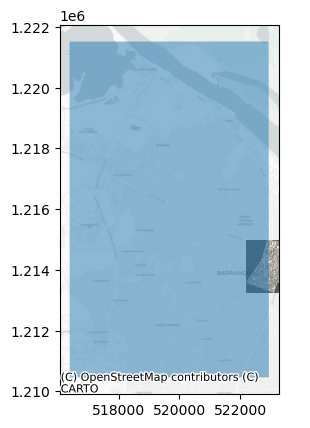

In [24]:
gdf = gpd.GeoDataFrame.from_features(aoi_geojson)
gdf = gdf.set_crs('epsg:4326')
gdf_proj = gdf.to_crs(epsg=32618)

f, ax = plt.subplots(1, 1)
with rasterio.open(tif_files[0]) as src:
    gdf_proj.plot(ax=ax, alpha=0.5) # AOI used for search
    ctx.add_basemap(ax, crs='epsg:32618', source=ctx.providers.CartoDB.Positron)
    rasterio.plot.show(src, ax=ax, alpha=0.6) # Resulting asset from the search
    plt.show()

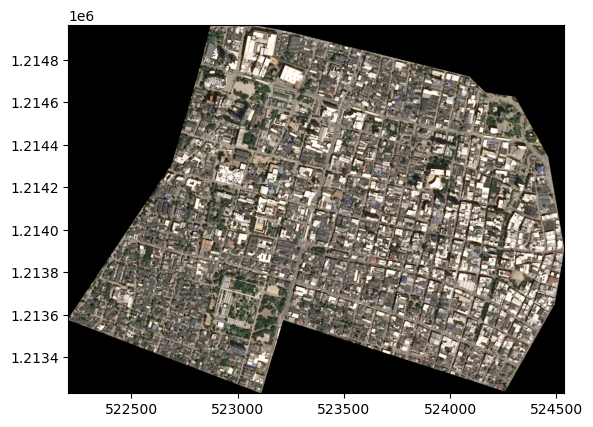

<AxesSubplot: >

In [25]:
# Read raster file with rasterio
raster = rasterio.open(tif_files[0])
rasterio.plot.show(raster)